**Project delivery 1**

Part 1: Text Processing and Exploratory Data Analysis

In [22]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
import nltk
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import time
import json
import re
import pandas as pd

****
**0. LOAD AND STRUCTURE**

For each tweet we have the following features:

- docID
- Tweet
- ID
- Date
- Hashtags
- Likes
- Retweets
- Url

In [24]:
# LOAD

# Open the file: Load data into memory
docs_path = '/content/Rus_Ukr_war_data.json'
with open(docs_path) as fp:
    # Read the file
    lines = fp.readlines()

data = []
for i in lines:
    data.append(json.loads(i))

# STRUCTURE

# docID | Tweet | ID | Date | Hashtags | Likes | Retweets | Url
# Create a list of dictionaries
tweet_dicts = []

for i in range(len(data)):
    doc_id = 'doc_' + str(i+1)
    tweet_text = data[i]['full_text']
    tweet_id = data[i]['id']
    tweet_date = data[i]['created_at']
    hashtags = [hashtag['text'] for hashtag in data[i]['entities']['hashtags']]
    likes = data[i]['favorite_count']
    retweets = data[i]['retweet_count']
    url = data[i]['entities']['urls'][0]['url'] if data[i]['entities']['urls'] else None

    # Create a dictionary for each tweet
    tweet_dict = {'DOC_ID': doc_id, 'Tweet Text': tweet_text, 'Tweet ID': tweet_id, 'Tweet Date': tweet_date, 'Hashtags': hashtags,
                  'Likes': likes, 'Retweets': retweets, 'URL': url}

    # Append the dictionary to the list
    tweet_dicts.append(tweet_dict)

print(tweet_dicts[400])

{'DOC_ID': 'doc_401', 'Tweet Text': 'Morning little buddy Zhang @ChinaAmbUN #JinPing #CCP little man #Putin has gone off the rails for everyone to see.  World has spoken my friend. You are backing a loser. Do the right thing before its too late to turn back the clock. #UkraineRussiaWar  @UKRinUN @USUN @RussiaUN https://t.co/kMwyzEHSvt', 'Tweet ID': 1575863777265942528, 'Tweet Date': 'Fri Sep 30 15:02:57 +0000 2022', 'Hashtags': ['JinPing', 'CCP', 'Putin', 'UkraineRussiaWar'], 'Likes': 1, 'Retweets': 0, 'URL': 'https://t.co/kMwyzEHSvt'}


****
**1. PRE-PROCESS THE DOCUMENTS**

In [25]:

def build_terms(line):
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))

    # Tweet Text and Tweet date to lowercase and tokenized
    line['Tweet Text']=  line['Tweet Text'].lower().split()
    line['Tweet Date']=  line['Tweet Date'].lower().split()

    # HASHTAGS
    # To lowercase
    line['Hashtags'] = [word.lower() for word in line['Hashtags']]
    #EXTRA-- DELETE SYMBOLS
    # Decided to delete the hashtags symbols as we have the list of hashtags in the dictionary
    line['Tweet Text'] = [re.sub(r"[^\w\s']+", '', word) for word in line['Tweet Text']]

    # DELETE PUNCTUATION
    # EXTRA IF word is a link NOT TO DELETE THE punctuation SYMBOLS
    line['Tweet Text'] = [re.sub(r"[,.;@#?!&$]+", '', word) for word in line['Tweet Text'] if not word.startswith('https')]

    # EXTRA-- DELETE EMPTY STRINGS ""
    line['Tweet Text']= [word for word in line['Tweet Text'] if word != '']

    #DELETE STOPWORDS
    line['Tweet Text']= [word for word in line['Tweet Text'] if word not in stop_words]

    # DEALING WITH STEMMING
    line['Tweet Text']= [stemmer.stem(word) for word in line['Tweet Text']]

    return line



In [26]:
#PROCESS ALL THE TWEETS
for tweet in tweet_dicts:
    tweet = build_terms(tweet)

print(tweet_dicts[2])

{'DOC_ID': 'doc_3', 'Tweet Text': ['alert', 'poland', 'prep', 'antiradi', 'tablet', 'nuclear', 'threat', 'nato', 'putin', 'russia', 'russiainvadedukrain', 'ukrain', 'ukrainerussiawar'], 'Tweet ID': 1575917992390823936, 'Tweet Date': ['fri', 'sep', '30', '18:38:23', '+0000', '2022'], 'Hashtags': ['nato', 'putin', 'russia', 'russiainvadedukraine', 'ukraine', 'ukrainerussiawar'], 'Likes': 0, 'Retweets': 0, 'URL': None}


In [27]:
print(tweet_dicts[7])

{'DOC_ID': 'doc_8', 'Tweet Text': ['ukrainerussiawar', 'ukrain', 'russia', 'osc', 'condemn', "russia'", 'illeg', 'annex', 'ukrainian', 'territori', 'call', 'russian', 'feder', 'withdraw', 'forc', 'across', 'ukrain'], 'Tweet ID': 1575917748978434053, 'Tweet Date': ['fri', 'sep', '30', '18:37:25', '+0000', '2022'], 'Hashtags': ['ukrainerussiawar', 'ukraine', 'russia', 'osce'], 'Likes': 0, 'Retweets': 0, 'URL': 'https://t.co/hLVEQLjYel'}


In [28]:
print(tweet_dicts[400])

{'DOC_ID': 'doc_401', 'Tweet Text': ['morn', 'littl', 'buddi', 'zhang', 'chinaambun', 'jinp', 'ccp', 'littl', 'man', 'putin', 'gone', 'rail', 'everyon', 'see', 'world', 'spoken', 'friend', 'back', 'loser', 'right', 'thing', 'late', 'turn', 'back', 'clock', 'ukrainerussiawar', 'ukrinun', 'usun', 'russiaun'], 'Tweet ID': 1575863777265942528, 'Tweet Date': ['fri', 'sep', '30', '15:02:57', '+0000', '2022'], 'Hashtags': ['jinping', 'ccp', 'putin', 'ukrainerussiawar'], 'Likes': 1, 'Retweets': 0, 'URL': 'https://t.co/kMwyzEHSvt'}


****
**2. Exploratory Data Analysis**

In [29]:
# Convert our dictionary to a dataframe
df = pd.DataFrame(tweet_dicts)
df.head()

,DOC_ID,Tweet Text,Tweet ID,Tweet Date,Hashtags,Likes,Retweets,URL
0,doc_1,"[melsimmonsfcdo, wrong, dictat, putin', fascis...",1575918221013979136,"[fri, sep, 30, 18:39:17, +0000, 2022]","[russiainvadesukraine, ukrainerussiawar]",0,0,None
1,doc_2,"[arm, forc, liber, villag, drobyshev, lymansk,...",1575918081461080065,"[fri, sep, 30, 18:38:44, +0000, 2022]","[drobysheve, lymansk, donetsk, ukrainerussiawa...",0,0,None
2,doc_3,"[alert, poland, prep, antiradi, tablet, nuclea...",1575917992390823936,"[fri, sep, 30, 18:38:23, +0000, 2022]","[nato, putin, russia, russiainvadedukraine, uk...",0,0,None
3,doc_4,"[im, still, wait, googl, map, updat, russia, n...",1575917907774967809,"[fri, sep, 30, 18:38:03, +0000, 2022]","[putin, ukrainerussiawar]",0,0,None
4,doc_5,"[emmanuelmacron, probabl, right, say, anyway, ...",1575917878410301441,"[fri, sep, 30, 18:37:56, +0000, 2022]","[european, ukrainerussiawar]",0,0,None


In [30]:
df.describe()

,Tweet ID,Likes,Retweets
count,4.000000e+03,4000.000000,4000.000000
mean,1.575564e+18,11.436250,2.123000
std,2.447583e+14,100.265304,15.828361
min,1.575154e+18,0.000000,0.000000
25%,1.575346e+18,0.000000,0.000000
50%,1.575594e+18,1.000000,0.000000
75%,1.575802e+18,3.000000,1.000000
max,1.575918e+18,3701.000000,646.000000



 1. Word Counting Distribution
 2. Average Sentence Length
 3. Vocabulary Size
 4. Ranking of tweets most retweeted
 5. Word clouds for the most frequent words
 6. Entity Recognition

The mean of the tweet length is:  17.139
The standard deviation of the tweet length is:  6.659073870757409


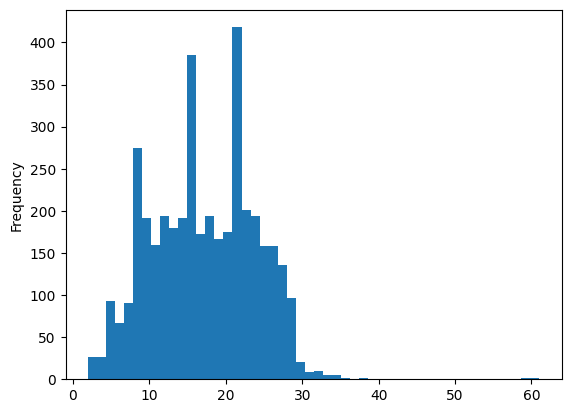

In [31]:
# 1. Word Counting Distribution

# Create a new column with the length of the tweet
df['Tweet Length'] = df['Tweet Text'].apply(len)
df.head()

# Plot the distribution of the tweet length
df['Tweet Length'].plot(bins=50, kind='hist')

# Print the mean of the tweet length
print('The mean of the tweet length is: ', df['Tweet Length'].mean())

# Print the standard deviation of the tweet length
print('The standard deviation of the tweet length is: ', df['Tweet Length'].std())




The mean of the tweet length is:  17.139
The standard deviation of the tweet length is:  6.659073870757409


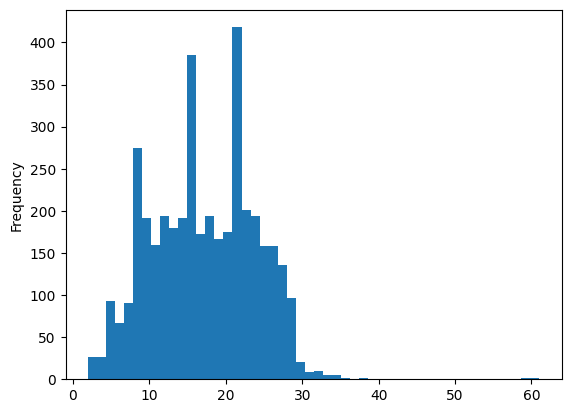

In [32]:
# 2. Average Sentence Length
# Create a new column with the length of the tweet
df['Sentence Length'] = df['Tweet Text'].apply(len)
df.head()

# Plot the distribution of the tweet length
df['Sentence Length'].plot(bins=50, kind='hist')

# Print the mean of the tweet length
print('The mean of the tweet length is: ', df['Sentence Length'].mean())

# Print the standard deviation of the tweet length
print('The standard deviation of the tweet length is: ', df['Sentence Length'].std())



The mean of the tweet length is:  17.139
The standard deviation of the tweet length is:  6.659073870757409


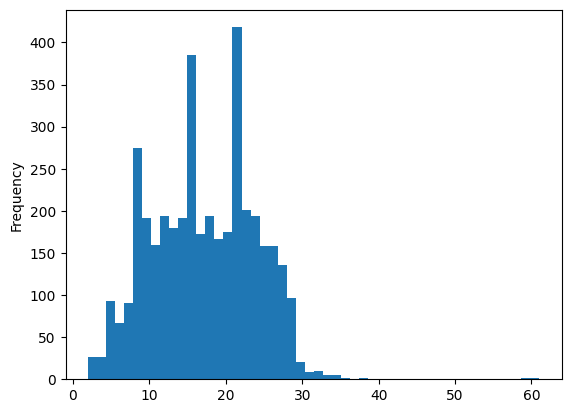

In [33]:

# 3. Vocabulary Size

# Create a new column with the length of the tweet
df['Vocabulary Size'] = df['Tweet Text'].apply(len)
df.head()

# Plot the distribution of the tweet length
df['Vocabulary Size'].plot(bins=50, kind='hist')

# Print the mean of the tweet length
print('The mean of the tweet length is: ', df['Vocabulary Size'].mean())

# Print the standard deviation of the tweet length
print('The standard deviation of the tweet length is: ', df['Vocabulary Size'].std())



In [34]:
# 4. Ranking of tweets most retweeted
# Sort the dataframe by the number of retweets
df.sort_values(by='Retweets', ascending=False).head(10)


,DOC_ID,Tweet Text,Tweet ID,Tweet Date,Hashtags,Likes,Retweets,URL,Tweet Length,Sentence Length,Vocabulary Size
1219,doc_1220,"[situat, around, lyman, sep, 30, 1100, ua, for...",1575775162674212865,"[fri, sep, 30, 09:10:49, +0000, 2022]",[ukrainerussiawar],3701,646,None,27,27,27
2813,doc_2814,"[uniqu, rare, photo, ukrainian, forward, comma...",1575396903252025351,"[thu, sep, 29, 08:07:45, +0000, 2022]","[kharkiv, ukrainerussiawar]",2685,338,None,18,18,18
3765,doc_3766,"[oper, interflex, ukrainian, recruit, continu,...",1575181552170201088,"[wed, sep, 28, 17:52:02, +0000, 2022]",[ukrainerussiawar],2155,283,None,13,13,13
1846,doc_1847,"[follow, countri, urg, citizen, leav, updat, g...",1575625313446289409,"[thu, sep, 29, 23:15:23, +0000, 2022]","[ukrainerussiawar, annexationofukraine, nafo]",923,251,None,24,24,24
1387,doc_1388,"[russian, shell, outskirt, zaporizhzhia, hit, ...",1575742923068813314,"[fri, sep, 30, 07:02:43, +0000, 2022]","[zaporizhzhia, ukrainerussiawar]",694,247,None,18,18,18
1209,doc_1210,"[war, end, call, annex, referendum, genuin, ex...",1575778551248605184,"[fri, sep, 30, 09:24:17, +0000, 2022]","[ukraine, ukrainerussiawar, nfts]",270,236,None,18,18,18
1532,doc_1533,"[russia, may, drop, 11, meter, long, x22, miss...",1575686562616004609,"[fri, sep, 30, 03:18:46, +0000, 2022]","[dnipro, natorussiawar, ukrainerussiawar, kher...",713,184,None,26,26,26
205,doc_206,"[ukrainian, forc, liber, drobyshev, donetsk, o...",1575896773511434240,"[fri, sep, 30, 17:14:04, +0000, 2022]","[donetsk, ukrainerussiawar]",1407,171,None,7,7,7
2118,doc_2119,"[kostyantyn, nemichev, command, kraken, specia...",1575559188079845376,"[thu, sep, 29, 18:52:37, +0000, 2022]",[ukrainerussiawar],1407,136,None,22,22,22
3801,doc_3802,"[ukrainian, paratroop, btr3, offens, kharkivdo...",1575178643772297216,"[wed, sep, 28, 17:40:28, +0000, 2022]","[kharkiv, donetsk, ukrainerussiawar]",1348,133,None,7,7,7


In [35]:
# 5. Word clouds for the most frequent words
# Create a list of all the words
all_words = []
for line in df['Tweet Text']:
    all_words.extend(line)

# Create a dictionary with the frequency of each word
word_freq = collections.Counter(all_words)
word_freq.most_common(10)

[('ukrainerussiawar', 3914),
 ('ukrain', 3253),
 ('russia', 1769),
 ('russian', 1543),
 ('ukrainewar', 1307),
 ('putin', 976),
 ('ukrainian', 924),
 ('nato', 595),
 ('war', 544),
 ('kherson', 530)]

In [36]:

# 6. Entity Recognition
# Create a list of all the words
all_words = []
for line in df['Tweet Text']:
    all_words.extend(line)

# Create a dictionary with the frequency of each word
word_freq = collections.Counter(all_words)
word_freq.most_common(10)

# Create a list of all the hashtags
all_hashtags = []
for line in df['Hashtags']:
    all_hashtags.extend(line)

# Create a dictionary with the frequency of each hashtag
hashtag_freq = collections.Counter(all_hashtags)
hashtag_freq.most_common(10)

# Create a list of all the dates
all_dates = []
for line in df['Tweet Date']:
    all_dates.extend(line)

# Create a dictionary with the frequency of each date
date_freq = collections.Counter(all_dates)
date_freq.most_common(10)


# Create a list of all the tweet texts
all_texts = []
for line in df['Tweet Text']:
    all_texts.extend(line)

# Create a dictionary with the frequency of each tweet text
text_freq = collections.Counter(all_texts)
text_freq.most_common(10)


[('ukrainerussiawar', 3914),
 ('ukrain', 3253),
 ('russia', 1769),
 ('russian', 1543),
 ('ukrainewar', 1307),
 ('putin', 976),
 ('ukrainian', 924),
 ('nato', 595),
 ('war', 544),
 ('kherson', 530)]

<Axes: xlabel='Likes', ylabel='Tweet Length'>

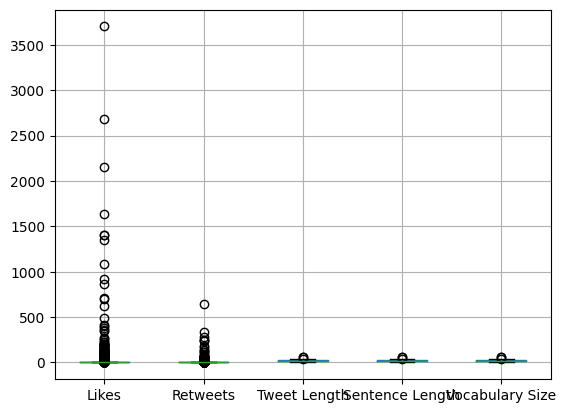

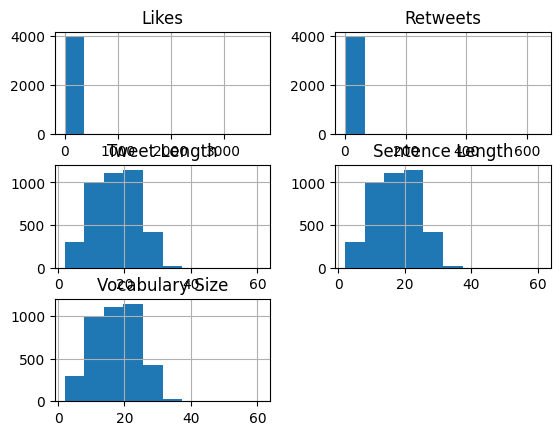

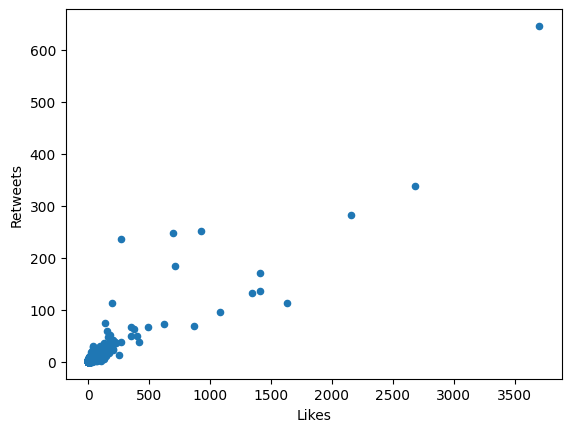

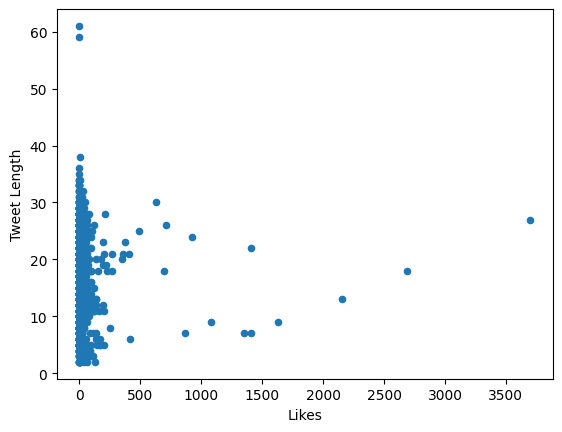

In [37]:

# do boxplots for the numerical variables
df.boxplot(column=['Likes', 'Retweets', 'Tweet Length', 'Sentence Length', 'Vocabulary Size'])

# do histograms for the numerical variables
df.hist(column=['Likes', 'Retweets', 'Tweet Length', 'Sentence Length', 'Vocabulary Size'])

# do scatterplots for the numerical variables
df.plot.scatter(x='Likes', y='Retweets')
df.plot.scatter(x='Likes', y='Tweet Length')
